In [2]:
%load_ext autoreload
%autoreload 2

train_path = "../Datasets/JSRT/Train"
test_path = "../Datasets/JSRT/Test"
val_path = "../Datasets/JSRT/Val" 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys 
sys.path.append('..')

In [4]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

from utils.graphDataLoader import LandmarksDataset, ToTensorSegHeart

from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

/home/hpcpin1/.conda/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             ToTensorSegHeart()])
                                 )

device = 'cpu'

Total of landmarks: 51


In [7]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5

double = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
double.load_state_dict(torch.load("../weights/Seg2Graph/double_s2g/bestMSE.pt", map_location=device))
double.eval()
print('Model loaded')

6-5
Model loaded


In [8]:
hybrid = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid.load_state_dict(torch.load("../weights/Seg2Graph/hybrid_s2g/bestMSE.pt", map_location=device))
hybrid.eval()
print('Model loaded')

Model loaded


In [10]:
config['layer'] = 6

Skip6 = Skip(config, D_t, U_t, A_t).to(device)
Skip6.load_state_dict(torch.load("../weights/Seg2Graph/skip_s2g/bestMSE.pt", map_location=device))
Skip6.eval()
print('Model loaded')

Model loaded


In [11]:
from models.pca import PCA_Net

config['extended'] = False
config['device'] = device

pcaNet = PCA_Net(config.copy()).to(device)
pcaNet.load_state_dict(torch.load('../weights/Seg2Graph/pca_s2g/bestMSE.pt', map_location=device))
pcaNet.eval()
print('Model loaded')

Model loaded


In [12]:
from models.vae import VAE_Mixed

config['allOrgans'] = False

vae = VAE_Mixed(config.copy()).to(device)
vae.load_state_dict(torch.load('../weights/Seg2Graph/vae_s2g/bestMSE.pt', map_location=device))
vae.eval()
print('Model loaded')

Model loaded


In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

model_list = [pcaNet, vae, hybrid, Skip6, double]
model_names = ['PCA', 'FC', 'HybridGNet','1-SC Layer 6', '2-SC Layers 6-5']

results1 = pd.DataFrame()

for i in range(0, len(test_dataset.images)):   
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['seg'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target[:120,:].reshape(-1).numpy()
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1)
            
            error = mean_squared_error(target * 1024, output * 1024)
            
            aux = pd.DataFrame([[i, error, model_names[j]]], columns=['i','MSE', 'Model'])
            results1 = results1.append(aux, ignore_index = True)

 7 of 51

KeyboardInterrupt: 

In [ ]:
import pathlib
import re

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

folder = "MultiAtlas/JSRT/labels/output_points"
test = "../Datasets/JSRT/Test/landmarks"

data_root = pathlib.Path(folder)
all_files = list(data_root.glob('*.npy'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

for i in range(0, len(all_files)):
    data = np.load(all_files[i])[:240]
    target = np.load(all_files[i].replace(folder, test))[:240]
    
    error = mean_squared_error(target, data)

    aux = pd.DataFrame([[i, error, "MultiAtlas"]], columns=['i','MSE', 'Model'])
    results1 = results1.append(aux, ignore_index = True)
    
model_names.append('MultiAtlas')

MSE
PCA 	77.205 +- 133.685
FC 	105.304 +- 172.994
HybridGNet 	96.857 +- 145.193
1-SC Layer 6 	70.735 +- 145.384
2-SC Layers 6-5 	55.164 +- 113.605
MultiAtlas 	343.866 +- 338.932



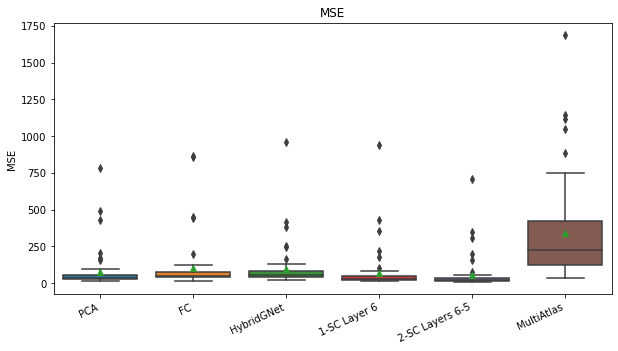

In [ ]:
plt.figure(figsize = (10,5))
plt.tight_layout()
sns.boxplot(x = 'Model', y = 'MSE', data = results1, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('MSE')
plt.title('MSE')
plt.xlabel(None)

print('MSE')
for model in model_names:
    print(model, '\t' '%.3f'%np.mean(results1['MSE'][results1['Model'] == model]), '+- %.3f' % np.std(results1['MSE'][results1['Model'] == model]))

print('')

In [ ]:
aux = results1[results1['Model'] == '2-SC Layers 6-5']
aux0 = aux.sort_values(by = 'MSE')[-5:]
aux0

,i,MSE,Model
84,16,157.286621,2-SC Layers 6-5
154,30,200.773102,2-SC Layers 6-5
54,10,308.679352,2-SC Layers 6-5
69,13,346.364349,2-SC Layers 6-5
224,44,705.194763,2-SC Layers 6-5


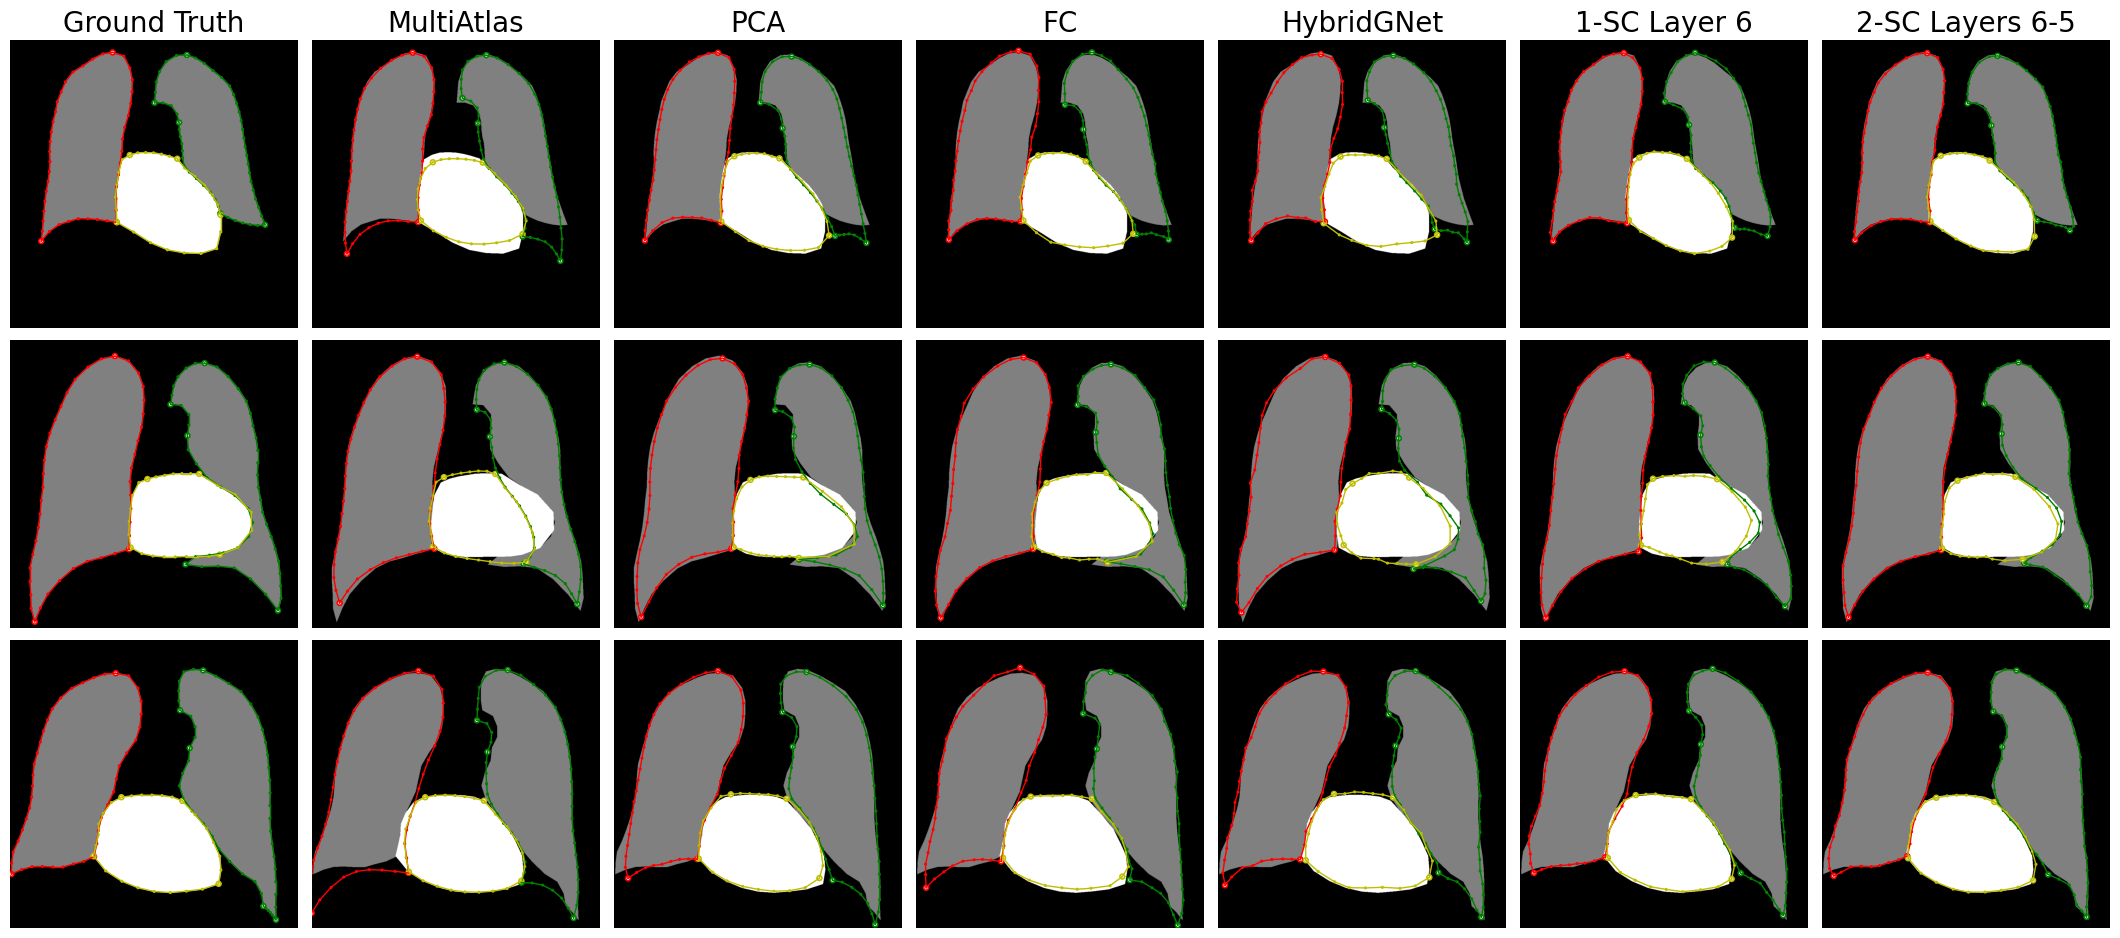

In [15]:
from utils.fun import drawOrgans

model_list = [pcaNet, vae, hybrid, Skip6, double]
model_names = ['PCA', 'FC', 'HybridGNet', '1-SC Layer 6', '2-SC Layers 6-5']

i_ =[10, 13, 44]

fig = plt.figure(figsize=(3 * (len(model_list)+2), 9), dpi= 100)

c = 0

for i in i_:
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['seg'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()

        draw = data.cpu().numpy()[0,0,:,:]

        ax = plt.subplot(3, len(model_list) + 2, 1 + c * (len(model_list) + 2))
        plt.axis('off')
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
        target = np.clip(target, 0, 1)
        
        drawOrgans(ax, target[:240] * 1024, None, draw.copy())
        if c == 0:
            plt.title("Ground Truth", fontsize = 20)
        
        ax = plt.subplot(3, len(model_list) + 2, 2 + c * (len(model_list) + 2))
        
        data_MA = test_dataset.images[i].replace('Datasets/JSRT/Test/landmarks', "Results/MultiAtlas/JSRT/labels/output_points").replace(".png", ".npy")
        data_MA = np.load(data_MA)[:240]
        
        plt.axis('off')
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        drawOrgans(ax, data_MA, None, draw.copy())
        if c == 0:
            plt.title("MultiAtlas", fontsize = 20)
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
            output = output.cpu().numpy().reshape(-1) 
            output = np.clip(output, 0, 1)[:240]
            ax = plt.subplot(3, len(model_list) + 2, j + 3 + c * (len(model_list) + 2))
            plt.axis('off')
            drawOrgans(ax, output * 1024, None, draw.copy())
            if c == 0:
                plt.title(model_names[j], fontsize = 20)
            
            plt.xlim(1, 1024)
            plt.ylim(1024, 1)
        
        c += 1
        
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0)      
plt.savefig('figs/s2g.png', bbox_inches = 'tight', dpi = 200)      
plt.savefig('figs/s2g.pdf', bbox_inches = 'tight', dpi = 200)

In [ ]:
from medpy.metric import dc, hd, assd, jc, asd
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target_lungs, target_heart):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)

    hdp = hd(ptest, target_lungs, voxelspacing = 0.35)
    dcp = dc(ptest, target_lungs)
    #assdp = asd(ptest, target_lungs, voxelspacing = 0.35)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest, target_heart, voxelspacing = 0.35)
    dcc = dc(ptest, target_heart)
    #assdc = asd(ptest, target_heart, voxelspacing = 0.35)
    
    return [dcp, dcc, hdp, hdc]#, assdp, assdc]

In [ ]:
blank = np.zeros([1024, 1024])

results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['seg'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        p1, p2, h, c1, c2 = reverseVector(target * 1024)
       
        t_lungs = drawBinary(blank.copy(), p1)
        t_lungs = drawBinary(t_lungs, p2)
        t_heart = drawBinary(blank.copy(), h)
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            output = output.cpu().numpy().reshape(-1) 
            
            metrics = evalImageMetrics(blank, output * 1024, t_lungs, t_heart)
             
            aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])#, 'ASD Lungs', 'ASD Heart'])
            results = results.append(aux, ignore_index = True)

 51 of 51

In [ ]:
for i in range(0, len(all_files)):
    print('\r',i+1,'of', len(all_files),end='')
    
    data = np.load(all_files[i])[:240]
    target = np.load(all_files[i].replace(folder, test))[:240]
    
    p1, p2, h, c1, c2 = reverseVector(target)
       
    t_lungs = drawBinary(blank.copy(), p1)
    t_lungs = drawBinary(t_lungs, p2)
    t_heart = drawBinary(blank.copy(), h)
        
    metrics = evalImageMetrics(blank, data, t_lungs, t_heart)
        
    aux = pd.DataFrame([[i, "MultiAtlas"] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])#, 'ASD Lungs', 'ASD Heart'])
    results = results.append(aux, ignore_index = True)
    
model_names.append('MultiAtlas')

 51 of 51

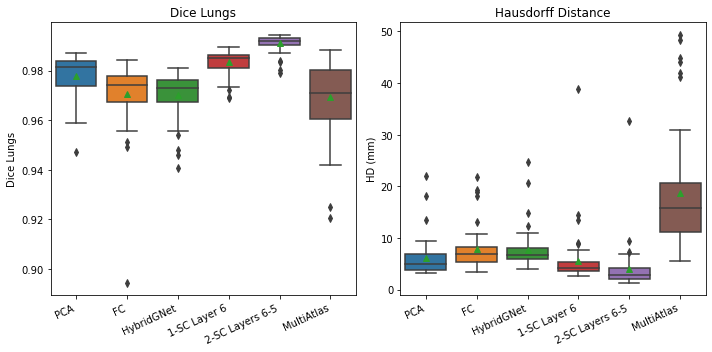

Dice
PCA 0.978 +- 0.009
FC 0.971 +- 0.014
HybridGNet 0.970 +- 0.009
1-SC Layer 6 0.983 +- 0.005
2-SC Layers 6-5 0.991 +- 0.003
MultiAtlas 0.969 +- 0.015

Hausdorff
PCA 6.025 +- 3.460
FC 7.819 +- 3.970
HybridGNet 7.668 +- 3.682
1-SC Layer 6 5.551 +- 5.253
2-SC Layers 6-5 3.919 +- 4.419
MultiAtlas 18.716 +- 11.165



In [ ]:
import matplotlib.ticker as mticker

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Lungs')
plt.title('Dice Lungs')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num2.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Lungs'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Lungs'][results['Model'] == model]))

print('')

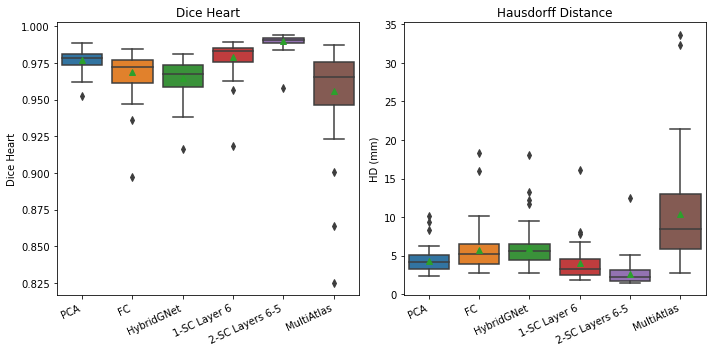

Dice
PCA 0.977 +- 0.007
FC 0.969 +- 0.014
HybridGNet 0.965 +- 0.013
1-SC Layer 6 0.979 +- 0.011
2-SC Layers 6-5 0.990 +- 0.005
MultiAtlas 0.956 +- 0.031

Hausdorff
PCA 4.366 +- 1.620
FC 5.778 +- 2.955
HybridGNet 6.036 +- 2.787
1-SC Layer 6 3.983 +- 2.249
2-SC Layers 6-5 2.620 +- 1.602
MultiAtlas 10.400 +- 6.651



In [ ]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Heart')
plt.title('Dice Heart')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num1.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Heart'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Heart'][results['Model'] == model]))

print('')

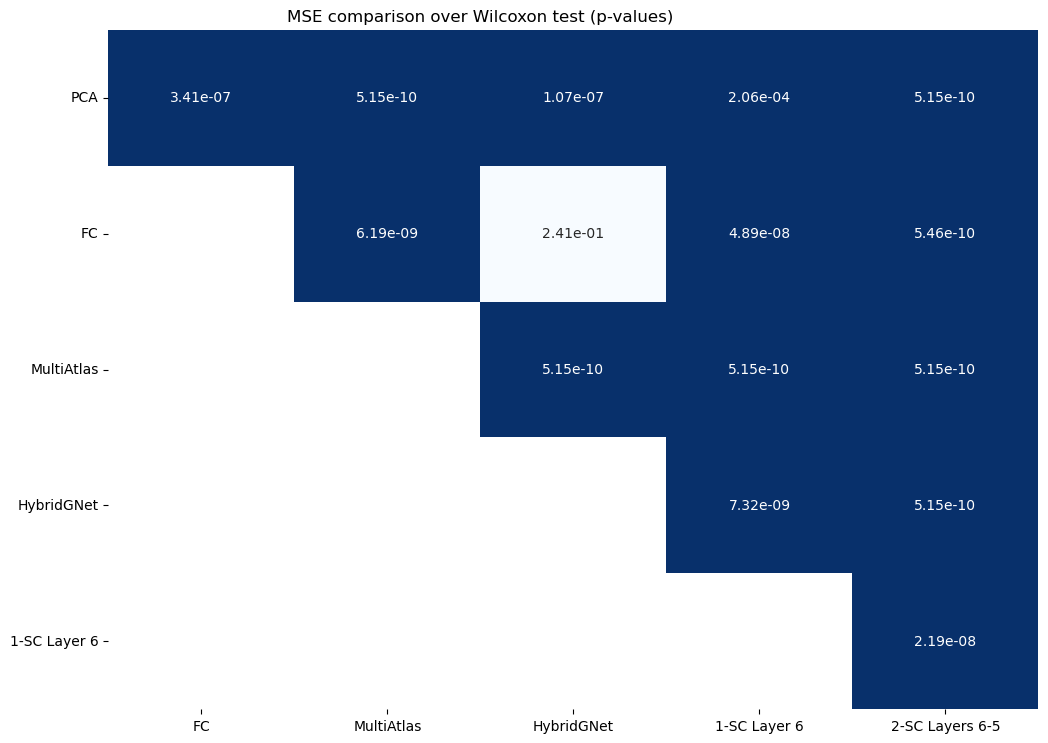

In [ ]:
from scipy.stats import wilcoxon

model_names = ['PCA', 'FC', 'MultiAtlas', 'HybridGNet', '1-SC Layer 6', '2-SC Layers 6-5']

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results1[results1['Model'] == model1]['MSE']
        mse2 = results1[results1['Model'] == model2]['MSE']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]
        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('MSE comparison over Wilcoxon test (p-values)', x = 0.4)

#plt.savefig('figs/MSE_wilcoxon.png', bbox_inches = 'tight')
plt.show()

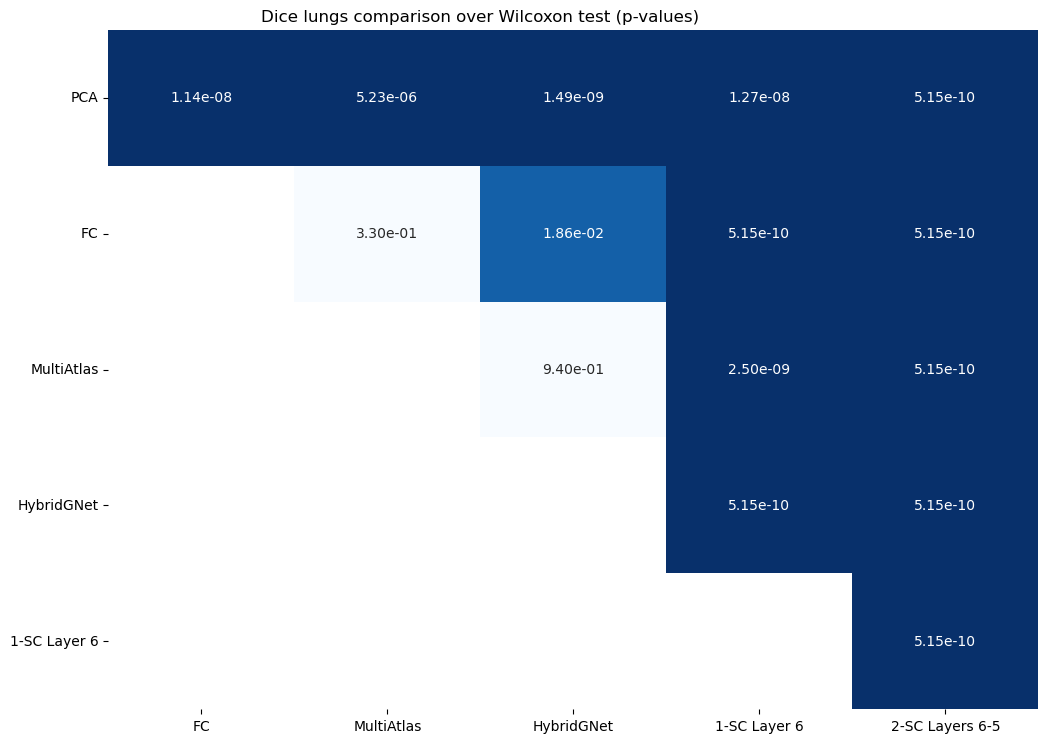

In [ ]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Lungs']
        mse2 = results[results['Model'] == model2]['Dice Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice lungs comparison over Wilcoxon test (p-values)', x = 0.4)

#plt.savefig('figs/dice_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

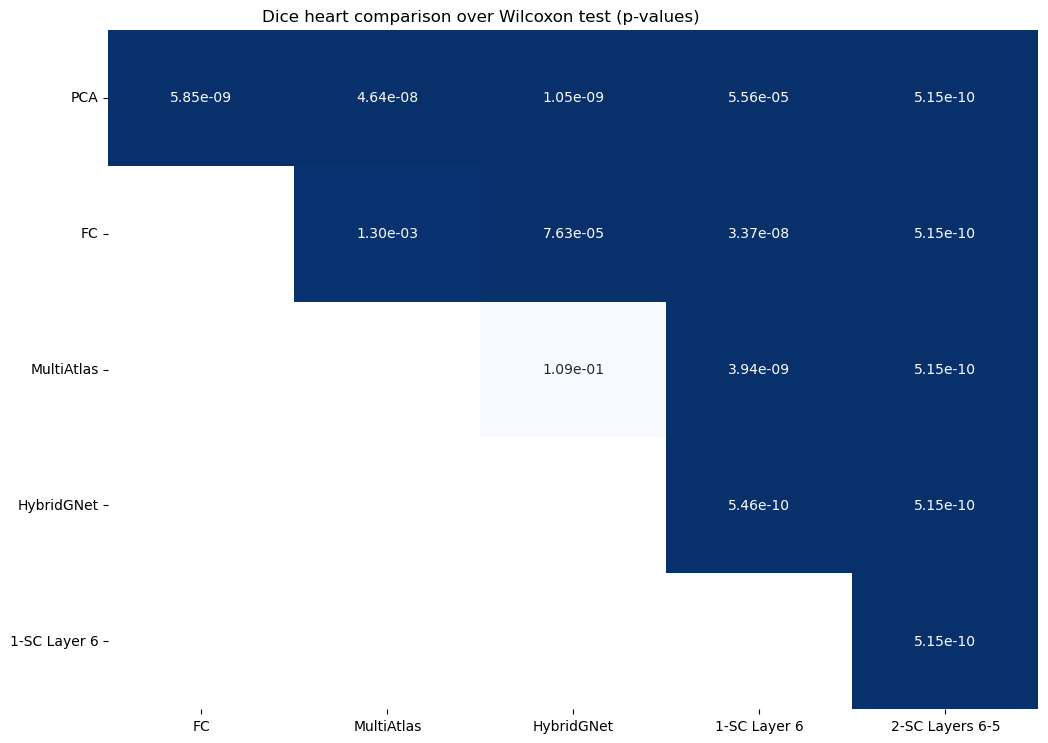

In [ ]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Heart']
        mse2 = results[results['Model'] == model2]['Dice Heart']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice heart comparison over Wilcoxon test (p-values)', x = 0.4)

#plt.savefig('figs/dice_wilcoxon_heart.png', bbox_inches='tight')
plt.show()

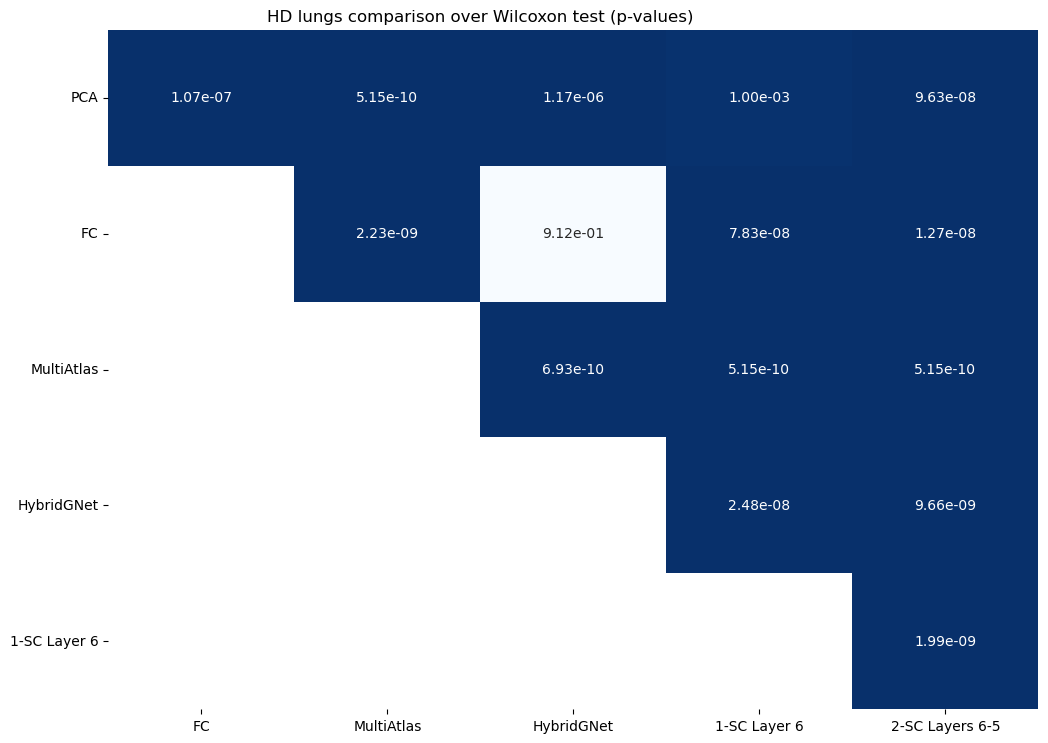

In [ ]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Lungs']
        mse2 = results[results['Model'] == model2]['HD Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD lungs comparison over Wilcoxon test (p-values)', x = 0.4)

#plt.savefig('figs/HD_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

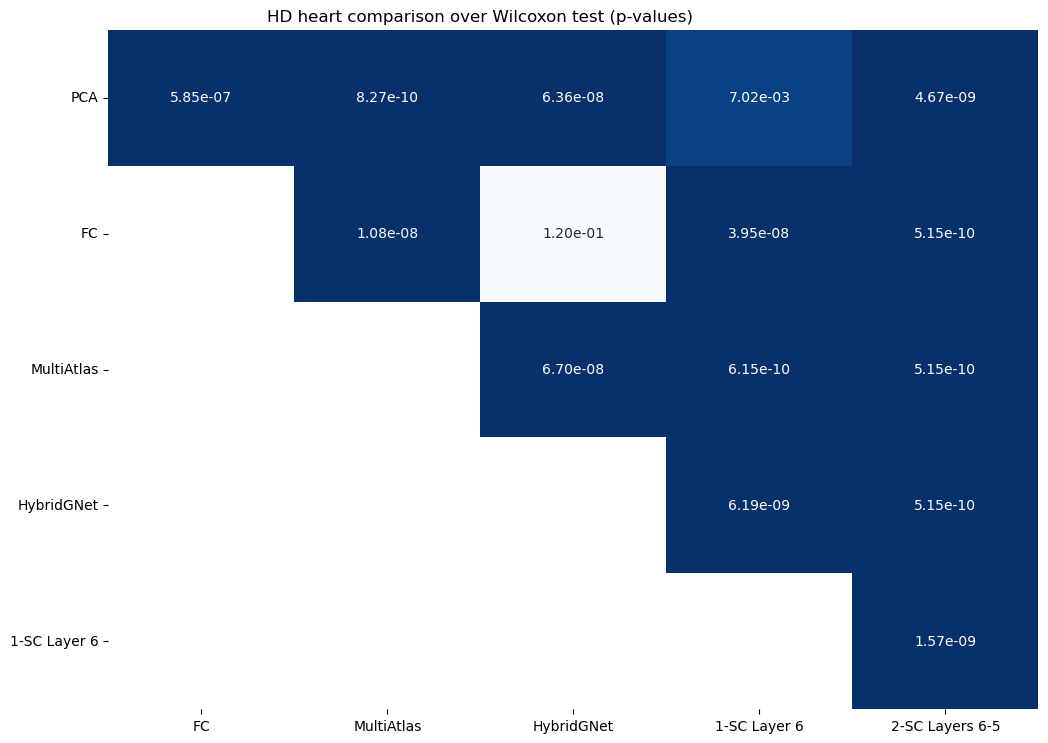

In [ ]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Heart']
        mse2 = results[results['Model'] == model2]['HD Heart']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD heart comparison over Wilcoxon test (p-values)', x = 0.4)

#plt.savefig('figs/HD_wilcoxon_heart.png', bbox_inches='tight')
plt.show()

In [ ]:
print("ok")

ok
